In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import cv2
import glob
import math
import shutil
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from MTM import matchTemplates

# Helper functions

DataFrame treatment functions

In [3]:
def create_aligned_path(path):
    items = path.split("/")
    items[0] += "-tm"
    return "/".join(items)

def get_file_size(file_path, unit='mb'):
    """ Get size of file at given path in bytes"""
    size = os.path.getsize(file_path)
    size = size/(1024*1024) if unit == 'mb' else size/(1024*1024*1024)
    return size

def get_parent_nodes(df):
    """Takes a a list with class_names of the parent nodes and returns a
        DataFrame containing only where the parent nodes are equal to 1"""
    
    parent_nodes = [
        'Enlarged Cardiomediastinum',
        'Lung Opacity',
        'Pleural Effusion',
        'No Finding',
        'Consolidation'
    ]
    
    dfs_to_keep = [df[df[cls] == 1.0] for cls in parent_nodes]
    parent_df = pd.concat(dfs_to_keep)
    parent_df = parent_df.drop_duplicates()
    return parent_df

Multi template matching functions

In [4]:
def read_image(path):
    image = imageio.imread(path, as_gray=True).astype('uint8')
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image


def get_cropped_image(image, bbox):
    x, y, w, h = bbox
    return image[y:(y + h), x:(x + w)]


def mtm(image, template):
    listTemplate = [('template', template)]
    hits = matchTemplates(listTemplate,
                          image,
                          N_object=1,
                          method=cv2.TM_CCOEFF_NORMED)
    return hits.values[0][1]

TfRecord functions

In [5]:
def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, list):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))
    else:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    if isinstance(value, (list, np.ndarray)):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
    else:
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def data_example(img, diseases):
    feature = {
        'img': bytes_feature(img.tostring()),
        'height': int64_feature(img.shape[0]),
        'width': int64_feature(img.shape[1]),
        'channels': int64_feature(img.shape[2]),
        'diseases': int64_feature(diseases)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# FOSCAL

In [19]:
foscal_df = pd.read_csv('csv/foscal.csv')

# BIMCV-COVID19 + Chest X-Ray Kaggle datasets

In [6]:
global_dset_df = pd.read_csv('csv/bimcv_and_chest_x_ray.csv')

Create aligned path

In [7]:
data_dir = '/data/DeepSARS/datasets/'
dset_original_source = os.path.join(data_dir, 'BIMCV-COVID19/')
dset_aligned_source = os.path.join(data_dir, 'BIMCV-COVID19-tm/')

Copy the folder structure to save the samples. Running this cell twice will raise an error if you don't delete the `dset_aligned_source`

In [ ]:
def ig_f(dir, files):
    return [f for f in files if os.path.isfile(os.path.join(dir, f))]

shutil.copytree(dset_original_source, dset_aligned_source, ignore=ig_f)

## Template Matching for the BIMCV-COVID19 samples

Choose and image as template

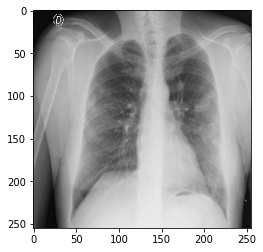

In [9]:
template_path = os.path.join(
    data_dir,
    global_dset_df[global_dset_df['split'] == 'test'].iloc[3]['original_path'])
template = read_image(template_path)
template = cv2.resize(template, (255, 255))
plt.imshow(template)

Start aligning the BIMCV-COVID19 **train** images

In [10]:
aligned_paths = []
for idx, row in tqdm(global_dset_df.iterrows()):
    if row['source'] == 'BIMCV-COVID19' and row['split'] == 'train':
        # Use the image_path to get the aligned_path, read
        # the image align it and save it to aligned_path.
        aligned_path = create_aligned_path(row['original_path'])
        aligned_paths.append(aligned_path)
        
        image_src_path = os.path.join(data_dir, row['original_path'])
        image_tgt_path = os.path.join(data_dir, aligned_path)
        image = read_image(image_src_path)
        image = cv2.resize(image, (285, 285))
        
        # Use the Multitemplate Matching Algorithm to obtain the part 
        # of the image that most closely resembles the template.
        bbox = mtm(image, template)
        cropped_image = get_cropped_image(image, bbox)
        
        # Save the image.
        imageio.imwrite(image_tgt_path, cropped_image)
    else:
        aligned_paths.append(row['original_path'])
        
global_dset_df.insert(2, 'aligned_path', aligned_paths)

7540it [03:57, 31.76it/s]


In [13]:
global_dset_df.to_csv('csv/bimcv_and_chest_x_ray_aligned.csv', index=False)

## Create TfRecord

In [12]:
save_path = 'tf_records/'
data_dir = '/data/DeepSARS/datasets/'
os.makedirs(save_path, exist_ok=True)
global_dset_df = pd.read_csv('csv/bimcv_and_chest_x_ray_aligned.csv')

Train

In [15]:
train_df = global_dset_df[global_dset_df['split'] == 'train']
train_tfrecord = os.path.join(save_path, 'bimcv_and_chest_x_ray_aligned_train.tfrecord')

with tf.io.TFRecordWriter(train_tfrecord) as writer:
    for idx, row in train_df.iterrows():
        image_path = os.path.join(data_dir, row['aligned_path'])
        image = read_image(image_path)
        image = cv2.resize(image, (255, 255))
        tf_example = data_example(image, row['diagnosis'])
        writer.write(tf_example.SerializeToString())
        
print('Global Classification Train TfRecord size in Gb:', get_file_size(train_tfrecord, unit='gb'))

Global Classification Train TfRecord size in Gb: 0.9085560422390699


Valid

In [16]:
valid_df = global_dset_df[global_dset_df['split'] == 'valid']
valid_tfrecord = os.path.join(save_path, 'bimcv_and_chest_x_ray_aligned_valid.tfrecord')

with tf.io.TFRecordWriter(valid_tfrecord) as writer:
    for idx, row in valid_df.iterrows():
        image_path = os.path.join(data_dir, row['aligned_path'])
        image = read_image(image_path)
        image = cv2.resize(image, (255, 255))
        tf_example = data_example(image, row['diagnosis'])
        writer.write(tf_example.SerializeToString())
        
print('Global Classification valid TfRecord size in Gb:', get_file_size(valid_tfrecord, unit='gb'))

Global Classification valid TfRecord size in Gb: 0.3893811609596014


### Verify

In [17]:
feature_dict = {
    'img': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),
    'diseases': tf.io.FixedLenFeature([], tf.int64),
}


def parse_img(example_proto):
    return tf.io.parse_single_example(example_proto, feature_dict)


def transform(img_features):
    img = tf.io.decode_raw(img_features['img'], tf.uint8)
    img = tf.reshape(img, (img_features['height'], img_features['width'],
                           img_features['channels']))
    diagnosis = img_features['diseases']
    return img, diagnosis

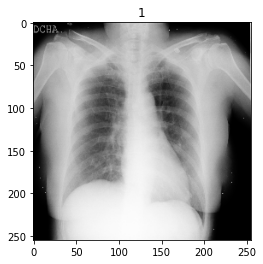

In [18]:
data = tf.data.TFRecordDataset('tf_records/bimcv_and_chest_x_ray_aligned_valid.tfrecord')
data_dict = data.map(parse_img, 24)
total_data = data_dict.map(transform, 24)

for i in total_data.take(1):
    break

plt.imshow(i[0].numpy(), cmap='gray')
plt.title(str(i[-1].numpy()));